In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from functools import reduce

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from meteora import qc

from uhi_cws_lausanne import plot_utils, qc_utils

In [ ]:
cws_ts_df_filepath = "../data/raw/cws-ts-df.csv"
official_ts_df_filepath = "../data/interim/official-ts-df.csv"

cws_stations_gdf_filepath = "../data/raw/cws-stations.gpkg"

dst_ts_df_filepath = "../data/interim/cws-qc-ts-df.csv"
# dst_stations_gdf_filepath = "../data/interim/cws-qc-stations.gpkg"

# for QC
unreliable_threshold = 0.2
lower_alpha = 0.01
upper_alpha = 0.95
radiative_error_max_prop_threshold = 0.2
station_indoor_corr_threshold = 0.9
adjust_elevation = True
atmospheric_lapse_rate = 0.0065  # K/m

# for plots
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

We start by reading the time series data for both the official stations and CWS:

In [ ]:
# 1. read official stations data
official_ts_df = pd.read_csv(
    official_ts_df_filepath, index_col=["heatwave", "time"], parse_dates=["time"]
)

# 2. read CWS data
# 2.1 stations locations
cws_stations_gdf = gpd.read_file(cws_stations_gdf_filepath).set_index("station_id")

# 2.2 time series data
cws_ts_df = pd.read_csv(
    cws_ts_df_filepath, index_col=["heatwave", "time"], parse_dates=["time"]
)

Let us see compare the number of stations:

In [ ]:
len(cws_ts_df.columns), len(official_ts_df.columns)

(238, 10)

and visualize the time series of measurements for the official stations and CWS separately:

## QC

As noted by Meier et al. (2017), multiple Netatmo stations can show identical location due to the automatic assignment based on the IP address of the wireless network. This QC check is independent of the time series of measurements so we will perform it first:

In [ ]:
mislocated_stations = qc.get_mislocated_stations(cws_stations_gdf["geometry"])
len(mislocated_stations)

20

As we can see, 20 stations have a non-unique location and will therefore be excluded from the data set:

In [ ]:
qc_ts_df, qc_dict = qc_utils.per_heatwave_qc(
    cws_ts_df.drop(columns=mislocated_stations, errors="ignore"),
    station_gdf=cws_stations_gdf,
    unreliable_threshold=unreliable_threshold,
    lower_alpha=lower_alpha,
    upper_alpha=upper_alpha,
    radiative_error_max_prop_threshold=radiative_error_max_prop_threshold,
    station_indoor_corr_threshold=station_indoor_corr_threshold,
    adjust_elevation=adjust_elevation,
    station_elevation=cws_stations_gdf["altitude"],
    atmospheric_lapse_rate=atmospheric_lapse_rate,
)

In [ ]:
summary_qc_df = pd.DataFrame(
    {
        qc_key: {
            heatwave: len(qc_heatwave_dict[heatwave]) for heatwave in qc_heatwave_dict
        }
        for qc_key, qc_heatwave_dict in qc_dict.items()
    }
)
summary_qc_df

,unreliable,radiative_error,daily_z_peak,indoor
2023/07/09-2023/07/11,16,11,36,37
2023/08/18-2023/08/25,10,10,52,40


Let us now assess the inter-heatwave QC, starting with the unreliable stations:

In [ ]:
unreliable_df = qc_utils.qc_aspect_df(qc_dict["unreliable"])
unreliable_df.sum().value_counts()

1    14
2     6
Name: count, dtype: int64

We continue by exploring the CWS that are located indoors:

2    28
1    21
Name: count, dtype: int64


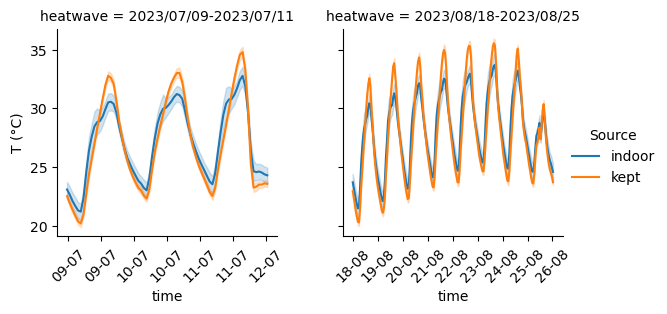

In [ ]:
indoor_df = qc_utils.qc_aspect_df(qc_dict["indoor"])
_ = plot_utils.comparison_lineplots(
    {
        "indoor": cws_ts_df[indoor_df.columns],
        "kept": cws_ts_df.drop(columns=indoor_df.columns),
    }
)
print(indoor_df.sum().value_counts())

A CWS showing a pattern of indoor temperatures for a given heatwave should be likely to show the same pattern at all heatwaves. However, we can see that many of the CWS showing indoor patterns show them during one or two heatwaves.

We can now explore the same for the CWS with systematic radiative errors:

2    8
1    5
Name: count, dtype: int64


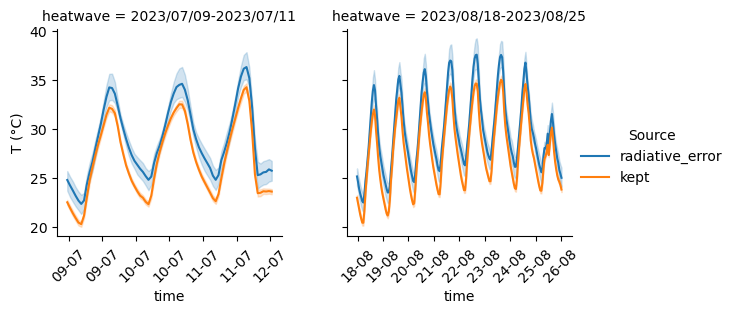

In [ ]:
radiative_error_df = qc_utils.qc_aspect_df(qc_dict["radiative_error"])
_ = plot_utils.comparison_lineplots(
    {
        "radiative_error": cws_ts_df[radiative_error_df.columns],
        "kept": cws_ts_df.drop(columns=radiative_error_df.columns),
    }
)
print(radiative_error_df.sum().value_counts())

A CWS showing systematic radiative errors suggests that it has been set up in a potentially sunlit location or that at least at times received direct short wave radiation [1, 2]. Likewise indoor stations, a CWS showing systematic radiative errors at a given heatwave should be likely to show systematic radiative errors at all heatwaves.

We can now explore the same for the CWS showing a daily peak on the Z-score, e.g., likely due to periodic overheating at a specific time of the day:

1    52
2    18
Name: count, dtype: int64


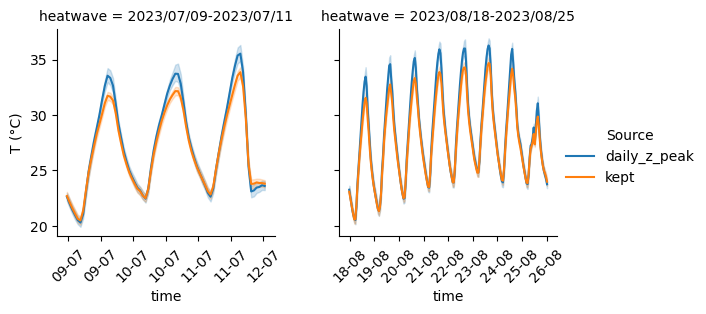

In [ ]:
daily_z_peak_df = qc_utils.qc_aspect_df(qc_dict["daily_z_peak"])
_ = plot_utils.comparison_lineplots(
    {
        "daily_z_peak": cws_ts_df[daily_z_peak_df.columns],
        "kept": cws_ts_df.drop(columns=daily_z_peak_df.columns),
    }
)
print(daily_z_peak_df.sum().value_counts())

In [ ]:
# QC
# ACHTUNG: we have already discarded the mislocated stations
discard_stations = list(
    set().union(
        set(
            reduce(
                pd.Index.union,
                [
                    unreliable_df.columns,
                    indoor_df.columns,
                    radiative_error_df.columns,
                    daily_z_peak_df.columns,
                ],
            )
        )
    )
)
qc_stations = qc_ts_df.columns.difference(discard_stations)
# qc_ts_df = cws_ts_df.drop(columns=discard_stations, errors="ignore")
len(discard_stations), len(qc_stations), len(qc_ts_df)

(139, 81, 268)

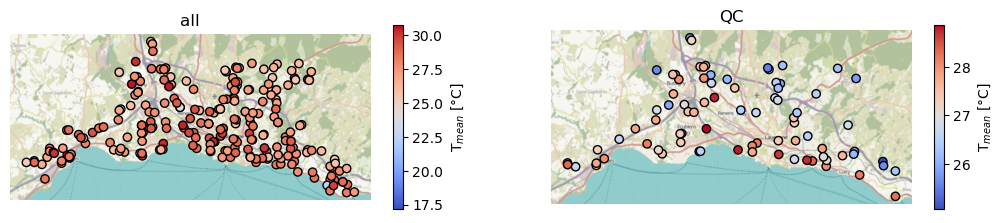

In [ ]:
# plot by average temperature
n_cols = 2
fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * figwidth, figheight))
plot_kwargs = {
    "legend_kwds": {"shrink": 0.5, "label": "T$_{mean}$ [$\degree$C]"},
    "cmap": "coolwarm",
}
for ts_df, title, ax in zip(
    [cws_ts_df, qc_ts_df[qc_stations]],
    ["all", "QC"],
    axes,
):
    _ = plot_utils.plot_map_by_var(
        cws_stations_gdf["geometry"],
        ts_df.mean(),
        ax=ax,
        **plot_kwargs,
    )
    ax.set_title(title)

In [ ]:
# dump to file (without discarded stations)
qc_ts_df[qc_stations].to_csv(dst_ts_df_filepath)

## References
1. Meier, F., Fenner, D., Grassmann, T., Otto, M., & Scherer, D. (2017). Crowdsourcing air temperature from citizen weather stations for urban climate research. Urban Climate, 19, 170-191.
2. Napoly, A., Grassmann, T., Meier, F., & Fenner, D. (2018). Development and application of a statistically-based quality control for crowdsourced air temperature data. Frontiers in Earth Science, 6, 118.